In [49]:
import itertools
import json
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('png', 'pdf')
set_matplotlib_formats('svg')

In [50]:
# Path to BERT directory, containing model checkpoints
bert_path = Path("~/om2/others/bert").expanduser()
# Base model used as init checkpoint for finetuning
bert_base_model = "uncased_L-12_H-768_A-12"
# Fine-tuning tasks / models
bert_models = [None, "MRPC", "CoLA", "MNLI", "RTE", "SST", "WNLI", "SNLI"]
# Describes the particular fine-tuning regime used
finetune_desc = "finetune-5000"

In [51]:
# For each model, load
# 1. brain decoding results
# 2. checkpoint data: global step, gradient norm information
model_decoding_perfs = {}
model_global_steps = {None: 0}
model_total_global_norms = {None: 0}
for model in bert_models:
    # brain decoding results
    decoding_perf_path = "perf.384sentences.bert.base%s.csv" % \
        ("" if model is None else ".%s-%s" % (finetune_desc, model))
    decoding_perf = pd.read_csv(decoding_perf_path, index_col=[0, 1])
    model_decoding_perfs[model] = decoding_perf.loc["ridge"]
    
    # checkpoint data
    from tensorflow.python.pywrap_tensorflow import NewCheckpointReader
    if model is None:
        model_dir = bert_path / bert_base_model
    else:
        model_dir = bert_path / ("%s.%s.%s" % (finetune_desc, bert_base_model, model))
    ckpt = NewCheckpointReader(str(model_dir / "model.ckpt"))
    if model is not None:
        model_global_steps[model] = ckpt.get_tensor("global_step")
        
    # events data
    import tensorflow as tf
    try:
        events_file = next(model_dir.glob("events.*"))
    except StopIteration:
        # no events data -- skip
        pass
    else:
        total_global_norm = 0.
        for e in tf.train.summary_iterator(str(events_file)):
            for v in e.summary.value:
                if v.tag == "grads/global_norm":
                    total_global_norm += v.simple_value
                    
        model_total_global_norms[model] = total_global_norm

In [52]:
df = pd.DataFrame([(model, model_decoding_perfs[model].mean().mean(), model_decoding_perfs[model].mean(axis=1).std(), model_global_steps[model],
                    model_total_global_norms[model])
                   for model in bert_models],
                  columns=["name", "perf_mean", "perf_std", "global_step", "total_global_norm"])
df

,name,perf_mean,perf_std,global_step,total_global_norm
0,None,96.226190,35.029161,0,0.000000
1,MRPC,131.154431,24.252570,5000,142.616803
2,CoLA,121.166005,30.508918,5000,209.854854
3,MNLI,117.606812,31.782626,5000,354.580172
4,RTE,109.732804,33.413293,5000,118.902519
5,SST,140.350529,21.220123,5000,243.424521
6,WNLI,117.740079,32.557098,5000,89.620783
7,SNLI,102.777447,35.232901,5000,345.591599


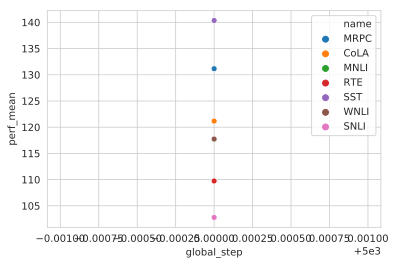

In [53]:
sns.scatterplot(data=df, y="perf_mean", x="global_step", hue="name")

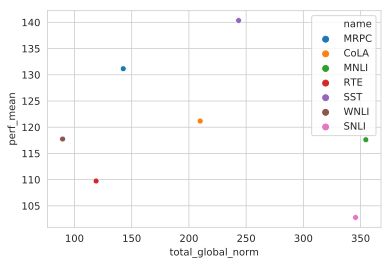

In [54]:
sns.scatterplot(data=df, y="perf_mean", x="total_global_norm", hue="name")

## Transfer checks

In [55]:
transfer_results = {}
for m1, m2 in itertools.product(bert_models, repeat=2):
    results_path = bert_path / "eval_transfer" / ("results-%s-%s.json" % (m1, m2))
    if not results_path.exists():
        continue
        
    with results_path.open("r") as results_f:
        transfer_results[m1, m2] = json.load(results_f)["results"]["eval_accuracy"]
        
pd.Series(transfer_results).reset_index()

,level_0,level_1,0
0,CoLA,MRPC,0.683824
1,CoLA,MNLI,0.348039
2,CoLA,RTE,0.541516
3,CoLA,SST,0.530963
4,CoLA,WNLI,0.563380
5,CoLA,SNLI,0.426539
6,MNLI,MRPC,0.683824
7,MNLI,CoLA,0.691275
